In [ ]:
!wget https://www-pequan.lip6.fr/%7Ebereziat/cours/master/vision/pdf/data.tgz

--2024-01-17 14:57:33--  https://www-pequan.lip6.fr/%7Ebereziat/cours/master/vision/pdf/data.tgz
Resolving www-pequan.lip6.fr (www-pequan.lip6.fr)... 132.227.74.4, 2001:660:3302:282a:204:e2ff:409:d49f
Connecting to www-pequan.lip6.fr (www-pequan.lip6.fr)|132.227.74.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3863283 (3.7M) [application/x-gzip]
Saving to: ‘data.tgz.1’

data.tgz.1          100%[===================>]   3.68M  1.98MB/s    in 1.9s    

2024-01-17 14:57:38 (1.98 MB/s) - ‘data.tgz.1’ saved [3863283/3863283]



In [ ]:
!tar -xvzf data.tgz

data/mysine/correct_mysine.png
data/mysine/mysine10.png
data/mysine/mysine9.png
data/mysine/._mysine_horn.png
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
data/mysine/mysine_horn.png
data/mysine/._mysine_lucas.png
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
data/mysine/mysine_lucas.png
data/nasa/nasa10.png
data/nasa/nasa9.png
data/nasa/._nasa_horn.png
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
data/nasa/nasa_horn.png
data/nasa/._nasa_lucas.png
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
data/nasa/nasa_lucas.png
data/rubberwhale/._correct_rubberwhal

In [ ]:
#!pip install optuna

In [ ]:
import matplotlib.pyplot as plt
from python.middlebury import computeColor, readflo
from PIL import Image
from numpy import gradient
import numpy as np
from scipy.signal import convolve2d
import optuna

## 1.  Write the function gradhorn(I1,I2) that takes two images as parameter and returns the spatiotemporal gradient of this pair of images.

In [ ]:
def gradhorn(I1,I2):
    dx=np.zeros((I1.shape[0],I1.shape[1]))
    dy=np.zeros((I1.shape[0],I1.shape[1]))
    dz=np.zeros((I1.shape[0],I1.shape[1]))

    dx[:-1,:-1]= I1[:-1,1:] #i j+1
    dx[:-1,:-1]-=I1[:-1,:-1] #i j
    dx[:-1,:-1]+= I1[1:,1:]  #i+1 j+1
    dx[:-1,:-1]-=I1[1:,:-1]  #i+1 j

    dx[:-1,:-1]+= I2[:-1,1:]  #i j+1
    dx[:-1,:-1]-=I2[:-1,:-1] #i j
    dx[:-1,:-1]+= I2[1:,1:]  #i+1 j+1
    dx[:-1,:-1]-=I2[1:,:-1]  #i+1 j

    dy[:-1,:-1]= I1[1:,:-1] #i j+1
    dy[:-1,:-1]-=I1[:-1,:-1] #i j
    dy[:-1,:-1]+= I1[1:,1:]  #i+1 j+1
    dy[:-1,:-1]-=I1[:-1,1:]  #i+1 j

    dy[:-1,:-1]+= I2[1:,:-1]  #i j+1
    dy[:-1,:-1]-=I2[:-1,:-1] #i j
    dy[:-1,:-1]+= I2[1:,1:]  #i+1 j+1
    dy[:-1,:-1]-=I2[:-1,1:]  #i+1 j

    dz[:-1,:-1]= I2[:-1,:-1] #i j+1
    dz[:-1,:-1]-= I1[:-1,:-1] #i j
    dz[:-1,:-1]+= I2[1:,:-1]  #i+1 j+1
    dz[:-1,:-1]-=I1[1:,:-1]  #i+1 j

    dz[:-1,:-1]+= I2[:-1,1:]  #i j+1
    dz[:-1,:-1]-=I1[:-1,1:] #i j
    dz[:-1,:-1]+= I2[1:,1:]  #i+1 j+1
    dz[:-1,:-1]-=I1[1:,1:]  #i+1 j

    return 0.25*dx, 0.25*dy, 0.25*dz

## 2. Write the function horn(I1,I2,alpha,N) that returns compute the velocity map between images I1 and I2 according to the Horn and Schunck method.

In [ ]:
def horn(I1, I2, alpha, N=200):
  Ix, Iy, It = gradhorn(I1,I2)

  u = np.zeros(I1.shape)
  v = np.zeros(I1.shape)

  A = np.array([[1/12, 1/6, 1/12], [1/6, 0, 1/6], [1/12, 1/6, 1/12]])

  for k in range(N):
    ubar = convolve2d(u, A, mode='same', boundary='wrap')
    vbar = convolve2d(v, A, mode='same', boundary='wrap')

    denominator = alpha + Ix**2 + Iy**2
    last_member = (Ix * ubar + Iy * vbar + It) / denominator
    u = ubar - Ix * last_member
    v = vbar - Iy * last_member

  return np.dstack((u,v))

## 3. Test your function on available data. For each data, you would provide a specific script that typically loads the data, computes the optical flow, displays the velocity map with computeColor().

### Error functions

Relative Norm Error

In [ ]:
def rne(Wr, We, eps=1e-10):
  return (np.linalg.norm(Wr) - np.linalg.norm(We)) / (np.linalg.norm(Wr) + eps)

End Point Error

In [ ]:
def epe(Wr, We):
  return np.linalg.norm(Wr - We)

Relative End Point Error

In [ ]:
def repe(Wr, We, eps=1e-10):
  return (np.linalg.norm(Wr - We)) / (np.linalg.norm(Wr) + eps)

Angular error

In [ ]:
def angular_error(Wr, We):
  return np.arccos((1 + np.dot(Wr.T, We)) / (np.sqrt(1 + np.linalg.norm(Wr)**2) * np.sqrt(1 + np.linalg.norm(We)**2)))

### Mysine

In [ ]:
def best_alpha(trial, I1=np.array(Image.open('data/mysine/mysine9.png').convert('L')), I2=np.array(Image.open('data/mysine/mysine10.png').convert('L')), Wr=readflo('data/mysine/correct_mysine.flo'), error_func=epe):
  alpha = trial.suggest_float("alpha", 0.01, 0.5)

  We = horn(I1, I2, alpha)
  error = error_func(Wr,We)
  mean_err = error.mean()

  return mean_err

study = optuna.create_study(direction='minimize')
study.optimize(best_alpha, n_trials=100)

alpha = study.best_params["alpha"]

[I 2024-01-17 14:58:16,995] A new study created in memory with name: no-name-a5eae630-4b79-42e9-a3b7-986d3ec7f436
[I 2024-01-17 14:58:17,248] Trial 0 finished with value: 0.024338257810069173 and parameters: {'alpha': 0.25684452999539786}. Best is trial 0 with value: 0.024338257810069173.
[I 2024-01-17 14:58:17,531] Trial 1 finished with value: 0.02434181003661694 and parameters: {'alpha': 0.09569649860454524}. Best is trial 0 with value: 0.024338257810069173.
[I 2024-01-17 14:58:17,813] Trial 2 finished with value: 0.02434302405031477 and parameters: {'alpha': 0.040606238873990196}. Best is trial 0 with value: 0.024338257810069173.
[I 2024-01-17 14:58:18,192] Trial 3 finished with value: 0.0243335503338996 and parameters: {'alpha': 0.470305824013319}. Best is trial 3 with value: 0.0243335503338996.
[I 2024-01-17 14:58:18,676] Trial 4 finished with value: 0.024341815428338465 and parameters: {'alpha': 0.09545184887992328}. Best is trial 3 with value: 0.0243335503338996.
[I 2024-01-17 1

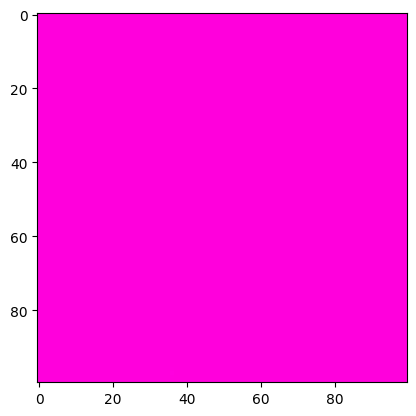

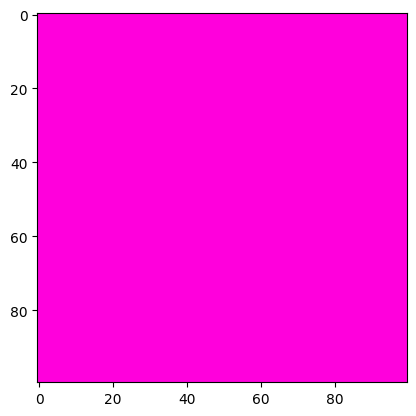

<function rne at 0x7a818f139870>
0.2940525409321131
0.0
<function epe at 0x7a818f139630>
41.58531419449753
0.0
<function repe at 0x7a818f139a20>
0.2940525767219558
0.0
<function angular_error at 0x7a81bf25a440>
1.5707255044321609
0.00499964497803562


In [ ]:
mysine1 = np.array(Image.open('data/mysine/mysine9.png').convert('L'))
mysine2 = np.array(Image.open('data/mysine/mysine10.png').convert('L'))

W = horn(mysine1, mysine2, alpha, 200)
plt.imshow(computeColor(W, True))
plt.show()

Wr = readflo('data/mysine/correct_mysine.flo')

true_mysine = np.array(Image.open('data/mysine/correct_mysine.png'))
plt.imshow(true_mysine)
plt.show()

for err_func in [rne, epe, repe, angular_error]:
    print(str(err_func))
    error = err_func(Wr,W)
    print(error.mean())
    print(error.std())

## Nasa

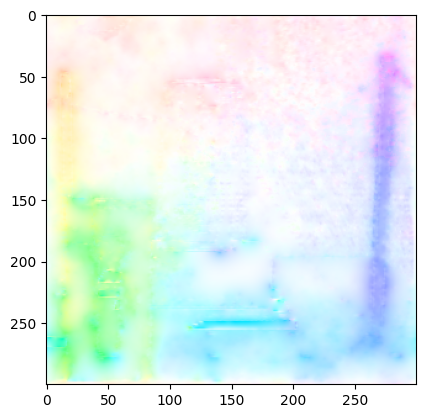

In [ ]:
nasa1 = np.array(Image.open('data/nasa/nasa9.png').convert('L'))
nasa2 = np.array(Image.open('data/nasa/nasa10.png').convert('L'))

W = horn(nasa1, nasa2, 1000, 200)
plt.imshow(computeColor(W, True))
plt.show()

## Rubberwhale

In [ ]:
def best_alpha(trial, I1=np.array(Image.open('data/rubberwhale/frame10.png').convert('L')), I2=np.array(Image.open('data/rubberwhale/frame11.png').convert('L')), Wr=readflo('data/rubberwhale/correct_rubberwhale10.flo'), error_func=epe):
  alpha = trial.suggest_float("alpha", 0.1, 10)

  We = horn(I1, I2, alpha)
  error = error_func(Wr,We)
  mean_err = error.mean()

  return mean_err

study = optuna.create_study(direction='minimize')
study.optimize(best_alpha, n_trials=20)

alpha = study.best_params["alpha"]

[I 2024-01-17 15:01:53,093] A new study created in memory with name: no-name-2e83f3c9-d732-4dcc-8505-59ba7d720d93
[I 2024-01-17 15:02:01,552] Trial 0 finished with value: 141852826142.81958 and parameters: {'alpha': 0.3215114291276776}. Best is trial 0 with value: 141852826142.81958.
[I 2024-01-17 15:02:07,206] Trial 1 finished with value: 141852826142.68063 and parameters: {'alpha': 6.298913964988794}. Best is trial 1 with value: 141852826142.68063.
[I 2024-01-17 15:02:14,814] Trial 2 finished with value: 141852826142.96634 and parameters: {'alpha': 9.521602928316799}. Best is trial 1 with value: 141852826142.68063.
[I 2024-01-17 15:02:21,300] Trial 3 finished with value: 141852826142.54874 and parameters: {'alpha': 0.5785804453164913}. Best is trial 3 with value: 141852826142.54874.
[I 2024-01-17 15:02:32,841] Trial 4 finished with value: 141852826142.32315 and parameters: {'alpha': 2.8746884831667057}. Best is trial 4 with value: 141852826142.32315.
[I 2024-01-17 15:02:40,752] Trial

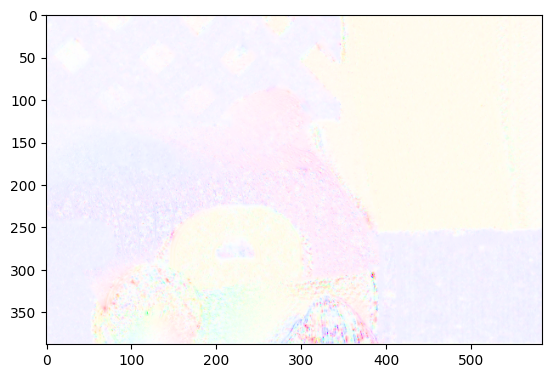

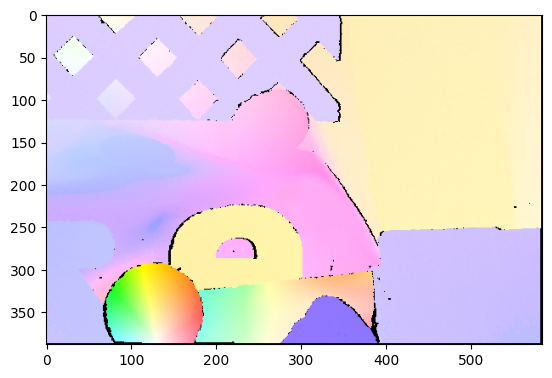

<function rne at 0x7a818f139870>
0.9999999997946719
0.0
<function epe at 0x7a818f139630>
141852826136.1912
0.0
<function repe at 0x7a818f139a20>
0.999999816092462
0.0
<function angular_error at 0x7a81bf25a440>
1.5707958901554397
0.0001406407139905466


In [ ]:
rubberwhale1 = np.array(Image.open('data/rubberwhale/frame10.png').convert('L'))
rubberwhale2 = np.array(Image.open('data/rubberwhale/frame11.png').convert('L'))

W = horn(rubberwhale1, rubberwhale2, alpha, 200)
plt.imshow(computeColor(W, True))
plt.show()

Wr = readflo('data/rubberwhale/correct_rubberwhale10.flo')

true_rubberwhale = np.array(Image.open('data/rubberwhale/correct_rubberwhale10.png'))
plt.imshow(true_rubberwhale)
plt.show()

for err_func in [rne, epe, repe, angular_error]:
    if err_func == angular_error:
        Wr = np.transpose(Wr, (1, 0, 2))

    print(str(err_func))
    error = err_func(Wr,W)
    print(error.mean())
    print(error.std())

## Rubic

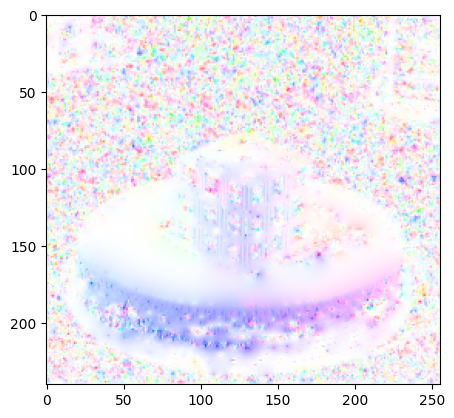

In [ ]:
rubic1 = np.array(Image.open('data/rubic/rubic9.png').convert('L'))
rubic2 = np.array(Image.open('data/rubic/rubic10.png').convert('L'))

W = horn(rubic1, rubic2, 0.1, 200)
plt.imshow(computeColor(W, True))
plt.show()

## Square

In [ ]:
def best_alpha(trial, I1=np.array(Image.open('data/square/square9.png').convert('L')), I2=np.array(Image.open('data/square/square10.png').convert('L')), Wr=readflo('data/square/correct_square.flo'), error_func=epe):
  alpha = trial.suggest_float("alpha", 1e-10, 1e-4)

  We = horn(I1, I2, alpha)
  error = error_func(Wr,We)
  mean_err = error.mean()

  return mean_err

study = optuna.create_study(direction='minimize')
study.optimize(best_alpha, n_trials=100)

alpha = study.best_params["alpha"]

[I 2024-01-17 15:07:39,573] A new study created in memory with name: no-name-e5a75a53-7e63-47ac-8890-abf24f78ab39
[I 2024-01-17 15:07:40,019] Trial 0 finished with value: 165.75879891348808 and parameters: {'alpha': 7.49496580617754e-05}. Best is trial 0 with value: 165.75879891348808.
[I 2024-01-17 15:07:40,521] Trial 1 finished with value: 165.75879893998686 and parameters: {'alpha': 6.0511092047650694e-05}. Best is trial 0 with value: 165.75879891348808.
[I 2024-01-17 15:07:41,036] Trial 2 finished with value: 165.75879897172035 and parameters: {'alpha': 4.322026834228538e-05}. Best is trial 0 with value: 165.75879891348808.
[I 2024-01-17 15:07:41,549] Trial 3 finished with value: 165.75879889976906 and parameters: {'alpha': 8.242482249718197e-05}. Best is trial 3 with value: 165.75879889976906.
[I 2024-01-17 15:07:42,024] Trial 4 finished with value: 165.75879904755382 and parameters: {'alpha': 1.900393297892087e-06}. Best is trial 3 with value: 165.75879889976906.
[I 2024-01-17 15

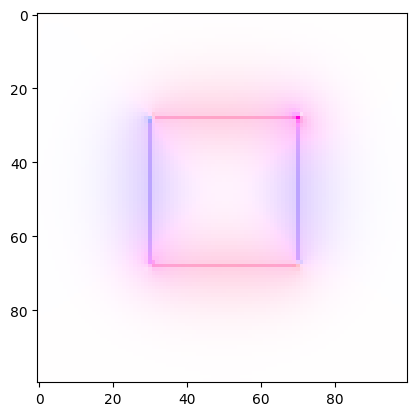

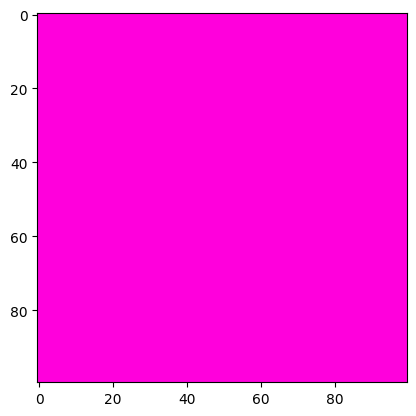

<function rne at 0x7a818f139870>
0.9521324199053017
0.0
<function epe at 0x7a818f139630>
183.710735215745
0.0
<function repe at 0x7a818f139a20>
0.9742950341779598
0.0
<function angular_error at 0x7a81bf25a440>
1.5702123199485887
0.0036462638518471153


In [ ]:
square1 = np.array(Image.open('data/square/square9.png').convert('L'))
square2 = np.array(Image.open('data/square/square10.png').convert('L'))

W = horn(square1, square2, alpha, 200)
plt.imshow(computeColor(W, True))
plt.show()

Wr = readflo('data/square/correct_square.flo')

true_square = np.array(Image.open('data/square/correct_square.png'))
plt.imshow(true_square)
plt.show()

for err_func in [rne, epe, repe, angular_error]:
    print(str(err_func))
    error = err_func(Wr,W)
    print(error.mean())
    print(error.std())

## Taxi

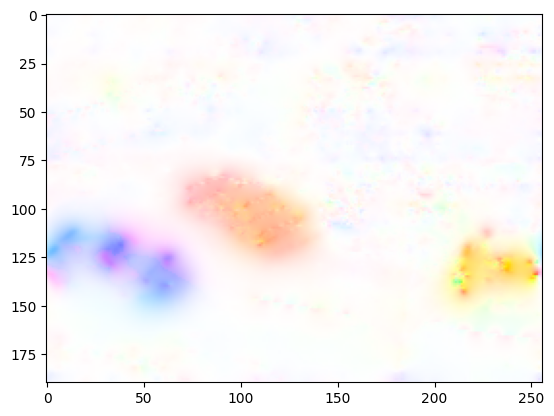

In [ ]:
taxi1 = np.array(Image.open('data/taxi/taxi9.png').convert('L'))
taxi2 = np.array(Image.open('data/taxi/taxi10.png').convert('L'))

W = horn(taxi1, taxi2, 1000, 200)
plt.imshow(computeColor(W, True))
plt.show()

## Yosemite

In [ ]:
def best_alpha(trial, I1=np.array(Image.open('data/yosemite/yos9.png').convert('L')), I2=np.array(Image.open('data/yosemite/yos10.png').convert('L')), Wr=readflo('data/yosemite/correct_yos.flo'), error_func=epe):
  alpha = trial.suggest_float("alpha", 750, 800)

  We = horn(I1, I2, alpha)
  error = error_func(Wr,We)
  mean_err = error.mean()

  return mean_err

study = optuna.create_study(direction='minimize')
study.optimize(best_alpha, n_trials=20)

alpha = study.best_params["alpha"]

[I 2024-01-17 15:14:33,606] A new study created in memory with name: no-name-563a34f0-9bc4-49d0-982b-4f55d454a6a3
[I 2024-01-17 15:14:36,940] Trial 0 finished with value: 419.54731645510344 and parameters: {'alpha': 766.8443492262631}. Best is trial 0 with value: 419.54731645510344.
[I 2024-01-17 15:14:38,934] Trial 1 finished with value: 419.54657889687587 and parameters: {'alpha': 764.3747895637817}. Best is trial 1 with value: 419.54657889687587.
[I 2024-01-17 15:14:40,924] Trial 2 finished with value: 419.5601689742812 and parameters: {'alpha': 789.1316730627441}. Best is trial 1 with value: 419.54657889687587.
[I 2024-01-17 15:14:42,904] Trial 3 finished with value: 419.5668873900085 and parameters: {'alpha': 796.6292678613964}. Best is trial 1 with value: 419.54657889687587.
[I 2024-01-17 15:14:45,669] Trial 4 finished with value: 419.5560802450112 and parameters: {'alpha': 783.7618389609509}. Best is trial 1 with value: 419.54657889687587.
[I 2024-01-17 15:14:49,011] Trial 5 fin

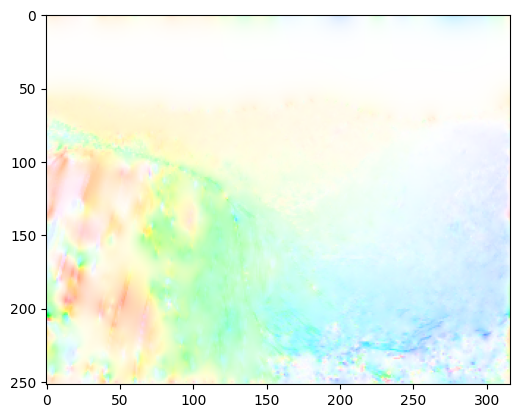

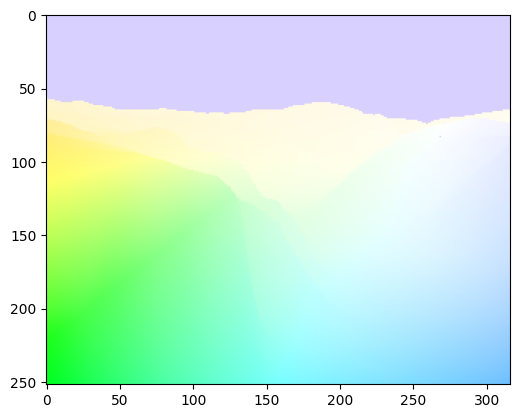

<function rne at 0x7a818f139870>
0.9125082590358
0.0
<function epe at 0x7a818f139630>
511.40046229132423
0.0
<function repe at 0x7a818f139a20>
0.9446800795562458
0.0
<function angular_error at 0x7a81bf25a440>
1.5705850342070231
0.0012837287066671255


In [ ]:
yosemite1 = np.array(Image.open('data/yosemite/yos9.png').convert('L'))
yosemite2 = np.array(Image.open('data/yosemite/yos10.png').convert('L'))

W = horn(yosemite1, yosemite2, alpha, 200)
plt.imshow(computeColor(W, True))
plt.show()

Wr = readflo('data/yosemite/correct_yos.flo')

true_yos = np.array(Image.open('data/yosemite/correct_yos.png'))
plt.imshow(true_yos)
plt.show()

for err_func in [rne, epe, repe, angular_error]:
    if err_func == angular_error:
        Wr = np.transpose(Wr, (1, 0, 2))

    print(str(err_func))
    error = err_func(Wr,W)
    print(error.mean())
    print(error.std())